# Use DeepCCA to transform ADNI features

## Importing Stuff

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import numpy as np
from linear_cca import linear_cca
from torch.utils.data import BatchSampler, SequentialSampler
from DeepCCAModels import DeepCCA
from main import Solver
from utils import load_data, svm_classify
from objectives import cca_loss
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pprint

## Read the database, examine it:

Instead of reading the whole database, we read only the data that's useful to us. That is, we read only specific columns of data, and we take only the row containing the first scan for each person. 

In "ADNI Regressional Analysis.ipynb" we have done that exactly, as well as performed linear regression transformation to the imaging data, in order to remove any age, sex, and DLICV_baseline effect. 

Furthermore, in "ADNI OPNMF.ipynb" we have performed dimensionality reduction through the OPNMF method, reducing the number of the ROIs from 145 to just 18. (Hasn't been done so this does not apply)

The data is located at "./DATA/Reduced_Linearly_Transformed_Unique_Dataset.pkl" 

(Need to run the RA code if data is not found)

In [20]:
unique = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(unique.shape)
unique.head(15)

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-126.260419,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,200.102369,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-60.539913,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1058.028132,...,1,0,0,0,1,0,0,0,1,1
84,002_S_1018,002_S_1018_2006-11-29,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,-485.048304,...,1,1,1,0,0,0,0,0,0,1


##  Building, training the DCCA Model

### Create the 2 views:

The first view consists of the imaging data, that are in the form of 145 real numbers. Those numbers are based on a prediction from a Linear Regression estimator trained only on the Cognitive Normal datapoints. The predictions then are subtracted from the actual values, and the remaining value (residual) is the datapoint for each ROI.

The second view consists of the 54 SNP (Single Nucleotide Polymorphism, "snip"), for each individual. They are either 0 or 1. 

The 2 views are the most basic views that can be used for the Deep CCA, and in further tests more features will be included.

In [21]:
# View 1:
view_1 = unique.loc[:,"MUSE_Volume_4":"MUSE_Volume_207"]

# View 2:
view_2 = unique.loc[:,"rs4575098":"rs429358"]

In [22]:
print("View 1:")
display(view_1.head())
print("View 2:")
display(view_2.head())

View 1:


,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,...,MUSE_Volume_198,MUSE_Volume_199,MUSE_Volume_200,MUSE_Volume_201,MUSE_Volume_202,MUSE_Volume_203,MUSE_Volume_204,MUSE_Volume_205,MUSE_Volume_206,MUSE_Volume_207
0,-401.428503,-475.082401,-38.009137,-25.646775,75.669198,126.590353,124.482040,54.813183,29.901574,4088.590752,...,789.359109,-170.422388,-1543.880458,-1674.618225,632.563713,-531.585707,-39.623451,260.649954,-115.085767,-81.954942
9,596.355045,-177.499304,34.866428,-42.623326,36.073837,53.399103,-914.581355,-108.931623,124.883198,-972.814733,...,1335.363413,2649.942277,1411.230818,31.346635,-1267.747385,117.940453,-149.481247,-535.823873,-40.431290,-470.993059
24,224.874560,1110.220538,134.798531,135.858384,109.271915,29.323465,1704.716715,-284.353318,-15.319536,-1099.592092,...,-1719.736333,-2192.002637,1513.234184,523.058557,1603.211181,2422.347525,218.967561,-66.321636,-200.393450,-107.128517
31,2633.277779,703.512999,-165.584181,-128.673356,-351.196493,-369.996116,-3669.094187,-871.937556,-752.247876,-503.572274,...,-616.963790,603.136888,-608.460701,-1332.047832,-3012.228200,-2804.914271,-791.597461,-822.562965,-356.240988,-118.945277
45,256.289641,599.953746,10.855725,32.230306,-150.404626,-107.055211,472.978958,649.045998,130.401624,-85.434102,...,-317.885924,-670.024556,62.647813,986.709609,-1459.773538,-1367.048968,-141.267965,-197.021311,-217.041629,-277.950585


View 2:


,rs4575098,rs6656401,rs2093760,rs4844610,rs4663105,rs6733839,rs10933431,rs35349669,rs6448453,rs190982,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,0,0,0,0,1,1,1,0,0,1,...,0,1,1,1,0,0,0,0,0,1
9,1,0,0,0,0,0,0,1,0,0,...,1,0,1,1,0,1,0,0,0,0
24,0,0,0,0,1,0,1,0,0,1,...,2,0,0,0,0,1,0,0,0,0
31,0,1,1,1,0,0,0,2,1,1,...,1,0,0,0,1,1,0,0,0,2
45,0,0,0,0,1,1,0,1,0,0,...,1,0,0,0,1,1,0,0,0,1


### Parameters:

In [23]:
# if a gpu exists, torch.device should be 'gpu'
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')
# print("Using", torch.cuda.device_count(), "GPUs")

# the size of the new space learned by the model (number of the new features)
outdim_size = 145

# size of the input for view 1 and view 2
input_shape1 = 145 # view_1.shape[1]
input_shape2 = 54  # view_2.shape[2]

# number of layers with nodes in each one
# this apparently can be different for each network, some experimentation is needed!
layer_sizes1 = [256, 1024, 1024, outdim_size]
layer_sizes2 = [256, 1024, 1024, outdim_size]
# layer_sizes1 = [64, 128, outdim_size]
# layer_sizes2 = [64, 128, outdim_size]
# the parameters for training the network
learning_rate = 1e-4
epoch_num = 150
epoch_log_freq = 50
batch_size = 1000

# the path to save the final learned features, as DCCA-o-d.
save_to = './DATA/ADNI_DCCA_features_'+str(outdim_size)+'_'+str(len(layer_sizes1)-1)+'.pkl'

# the regularization parameter of the network
# seems necessary to avoid the gradient exploding especially when non-saturating activations are used
reg_par = 1e-3

# specifies if all the singular values should get used to calculate the correlation or just the top 
# outdim_size ones
# if one option does not work for a network or dataset, try the other one
use_all_singular_values = False

# if a linear CCA should get applied on the learned features extracted from the networks
# it does not affect the performance on noisy MNIST significantly
apply_linear_cca = True

###  Training the DCCA model:

In [24]:
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()

In [25]:
# View 1:
view_1 = unique.loc[:,"MUSE_Volume_4":"MUSE_Volume_207"]
# View 2:
view_2 = unique.loc[:,"rs4575098":"rs429358"]
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()
# Scramble the datapoints for randomness:
indices = np.arange(view_1_n.shape[0])
# np.random.shuffle(indices)
view_1_n = view_1_n[indices]
view_2_n = view_2_n[indices].astype(np.float64) # DeepCCA MLP requires double type

print(view_1_n.shape, type(view_1_n), view_1_n.dtype)
print(view_2_n.shape, type(view_2_n), view_2_n.dtype)

view_1_t = torch.from_numpy(view_1_n)
print(view_1_t.shape, type(view_1_t))
view_2_t = torch.from_numpy(view_2_n)
print(view_2_t.shape, type(view_2_t))

data1 = view_1_t
data2 = view_2_t

(1302, 145) <class 'numpy.ndarray'> float64
(1302, 54) <class 'numpy.ndarray'> float64
torch.Size([1302, 145]) <class 'torch.Tensor'>
torch.Size([1302, 54]) <class 'torch.Tensor'>


In [87]:
data1 = view_1_t
data2 = view_2_t

model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                input_shape2, outdim_size, use_all_singular_values, device=device).double()
l_cca = None
if apply_linear_cca:
    l_cca = linear_cca()
    
    
solver = Solver(model, l_cca, outdim_size, epoch_num, batch_size,
                learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=False)
s_1, s_2 = data1.shape[0], data2.shape[0]

# Split the dataset into training, validation and testing (75%-15%-10%):
train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
training_losses, val_losses = solver.get_losses()
# TODO: Save linear_cca model if needed

loss on validation data: -107.6490
loss on test data: -114.0847


In [88]:
set_size = [0, 
            train1.size(0), 
            train1.size(0) + val1.size(0), 
            train1.size(0) + val1.size(0) + test1.size(0)]

losses, outputs = solver._get_outputs(data1, data2)
losses = np.round(losses,3)
print(losses)

[-137.345  -86.334]


In [89]:
print(type(outputs[0]))
print(outputs[0].shape)
print(type(outputs[1]))
print(outputs[1].shape)

<class 'numpy.ndarray'>
(1302, 145)
<class 'numpy.ndarray'>
(1302, 145)


### Plotting the Losses:

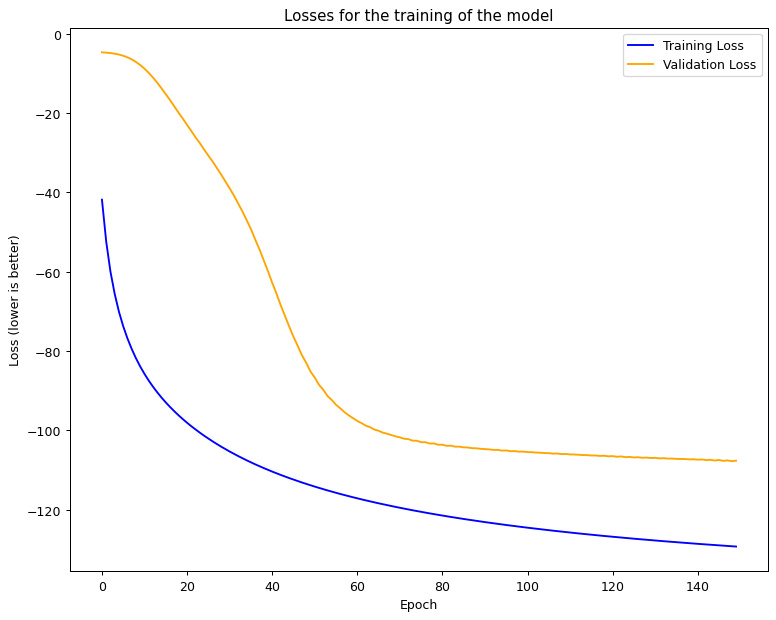

In [90]:
x = np.arange(epoch_num)
plt.figure(figsize=(10, 8), dpi=90)
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

## Producing the best new features by DCCA

### Using GridSearch Cross with Validation to find the best parameters:

In [8]:

# View 1:
view_1 = unique.loc[:,"MUSE_Volume_4":"MUSE_Volume_207"]
# View 2:
view_2 = unique.loc[:,"rs4575098":"rs429358"]
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()
# Scramble the datapoints for randomness:
indices = np.arange(view_1_n.shape[0])
# np.random.shuffle(indices)
view_1_n = view_1_n[indices]
view_2_n = view_2_n[indices].astype(np.float64) # DeepCCA MLP requires double type

print(view_1_n.shape, type(view_1_n), view_1_n.dtype)
print(view_2_n.shape, type(view_2_n), view_2_n.dtype)

view_1_t = torch.from_numpy(view_1_n)
print(view_1_t.shape, type(view_1_t))
view_2_t = torch.from_numpy(view_2_n)
print(view_2_t.shape, type(view_2_t))

data1 = view_1_t
data2 = view_2_t

# Standard parameters that shouldn't be changed:
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')
input_shape1 = 145 # view_1.shape[1]
input_shape2 = 54  # view_2.shape[2]
epoch_log_freq = 50
use_all_singular_values = False
apply_linear_cca = True
epoch_num = 100

# Parameters that should be explored, example values:
outdim_sizes = [10,50,100,150]
hidden_layer_sizes = [[256,256,256],
                      [1024,1024,1024],
                      [256,256,256,256],
                      [1024,1024,1024,1024]]
learning_rates = [1e-2,1e-3,1e-4]
batch_sizes = [500,1000]
reg_pars = [1e-2,1e-3,1e-4]

results = []
best_test_loss = (1000,None)
count=0

for outdim_size in outdim_sizes:
    for hidden_layer_size in hidden_layer_sizes:
        hidden_layer_size1 = hidden_layer_size
        hidden_layer_size2 = hidden_layer_size
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                for reg_par in reg_pars:
                    count += 1
                    parameters = {"outdim": outdim_size,
                                  "hidden_layer_size1": hidden_layer_size1,
                                  "hidden_layer_size2": hidden_layer_size2,
                                  "learning_rate": learning_rate,
                                  "batch_sz": batch_size,
                                  "reg_par": reg_par}
                    print("Variation ", count, ":", parameters)
                    layer_sizes1 = hidden_layer_size1 + [outdim_size]
                    layer_sizes2 = hidden_layer_size2 + [outdim_size]

                    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, 
                                    use_all_singular_values, device=device).double()

                    solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size,
                                    learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=False)
                    s_1, s_2 = data1.shape[0], data2.shape[0]

                    # Split the dataset into training, validation and testing (75%-15%-10%):
                    train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
                    val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
                    test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

                    test_loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
                    print(test_loss)
                    if test_loss < best_test_loss[0]:
                        best_test_loss = (test_loss, parameters)
                    training_losses, val_losses = solver.get_losses()
                    results.append((training_losses, val_losses, test_loss, parameters))

print("With a loss of " + str(best_test_loss[0]) + ", the configuration with the best Test loss was:")
pprint.pprint(best_test_loss[1])

(1302, 145) <class 'numpy.ndarray'> float64
(1302, 54) <class 'numpy.ndarray'> float64
torch.Size([1302, 145]) <class 'torch.Tensor'>
torch.Size([1302, 54]) <class 'torch.Tensor'>
Variation  1 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.01}
loss on validation data: -2.0691
loss on test data: -2.5383
-2.538331363387658
Variation  2 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.001}
loss on validation data: -1.8383
loss on test data: -2.4037
-2.4036840246919575
Variation  3 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.0001}
loss on validation data: -1.8182
loss on test data: -2.3320
-2.332039944771727
Variation  4 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_s

In [9]:
with open("InitialGridSearch_Results.pkl", "wb") as fp:   #Pickling
    pickle.dump(results, fp)

### Saving the new features:

In [18]:
# Saving new features in a gzip pickled file specified by save_to
with open(save_to, 'wb') as f:
    pickle.dump(outputs, f)

### Loading the model:

In [19]:
# d = torch.load('checkpoint.model')
# solver.model.load_state_dict(d)
# solver.model.parameters()

### Using the model with the best parameters:

The nunmber of different results are:  288

The best test loss that was managed is:  -128.82043919333248
The test loss was managed with the following parameters:
{'batch_sz': 1000,
 'hidden_layer_size1': [1024, 1024, 1024, 1024],
 'hidden_layer_size2': [1024, 1024, 1024, 1024],
 'learning_rate': 0.001,
 'outdim': 150,
 'reg_par': 0.0001}



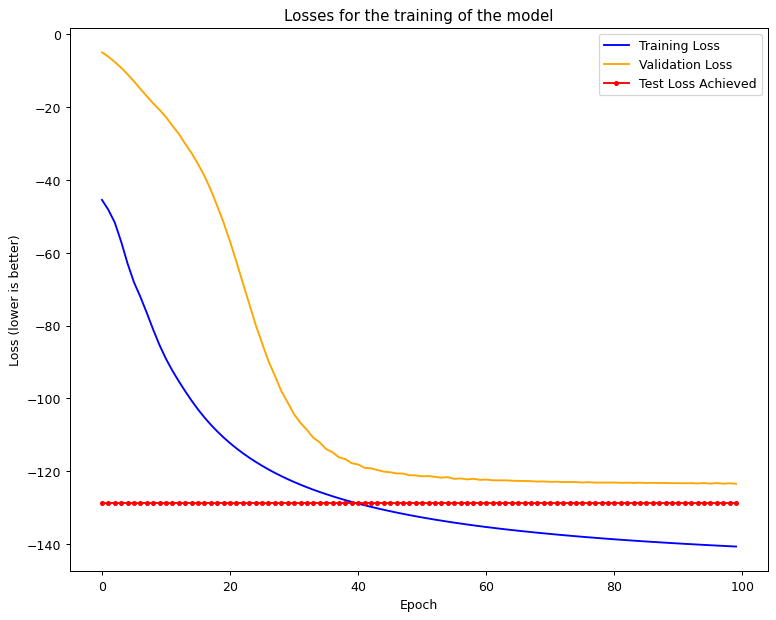

In [16]:
with open("InitialGridSearch_Results.pkl", "rb") as fp:   # Unpickling
    results = pickle.load(fp)

print("The nunmber of different results are: ", len(results))
print()
# each result is in the format ([training_losses], [validation_losses], test_loss, parameters):
from operator import itemgetter

best_test_loss = min(results, key=itemgetter(2))
print("The best test loss that was managed is: ", best_test_loss[2])
print("The test loss was managed with the following parameters:")
pprint.pprint(best_test_loss[3])
print()

x = np.arange(len(best_test_loss[0])) # number of epochs in training, also in validation
plt.figure(figsize=(10, 8), dpi=90)
training_losses = best_test_loss[0]
val_losses = best_test_loss[1]
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.plot(x, [best_test_loss[2]]*len(best_test_loss[0]), marker='.', color='red', label="Test Loss Achieved")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

In [26]:
# Standard parameters that shouldn't be changed:
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')
input_shape1 = 145 # view_1.shape[1]
input_shape2 = 54  # view_2.shape[2]
epoch_log_freq = 50
use_all_singular_values = False
apply_linear_cca = True
epoch_num = 300

parameters=best_test_loss[3]

batch_size=parameters['batch_sz']
hidden_layer_size1 = parameters['hidden_layer_size1']
hidden_layer_size2 = parameters['hidden_layer_size2']
learning_rate = parameters['learning_rate']
outdim_size = parameters['outdim']
reg_par = parameters['reg_par']
layer_sizes1 = hidden_layer_size1 + [outdim_size]
layer_sizes2 = hidden_layer_size2 + [outdim_size]

model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, use_all_singular_values, device=device).double()
solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size, learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=False)

s_1, s_2 = data1.shape[0], data2.shape[0]
# Split the dataset into training, validation and testing (75%-15%-10%):
train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
training_losses, val_losses = solver.get_losses()
# TODO: Save linear_cca model if needed

[ INFO : 2022-03-15 14:08:14,037 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=145, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, tra

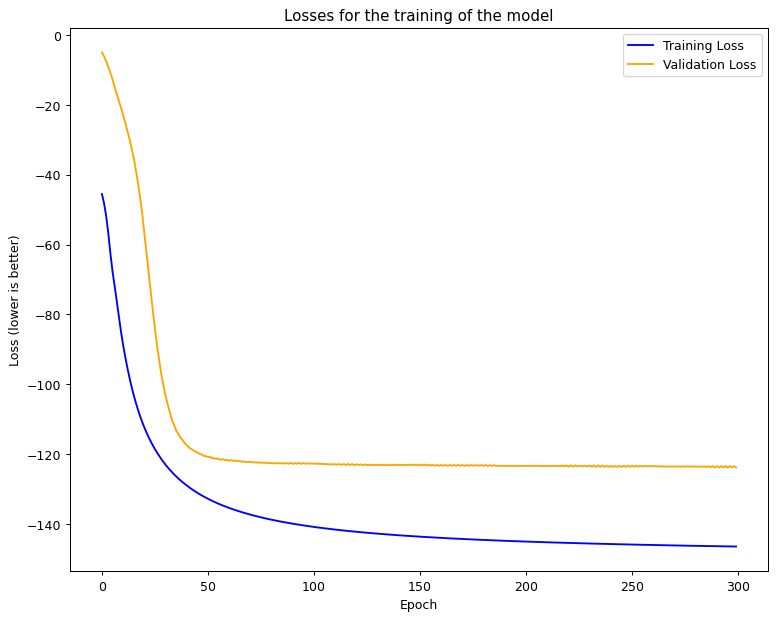

In [28]:
x = np.arange(epoch_num)
plt.figure(figsize=(10, 8), dpi=90)
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

In [29]:
set_size = [0, 
            train1.size(0), 
            train1.size(0) + val1.size(0), 
            train1.size(0) + val1.size(0) + test1.size(0)]

losses, outputs = solver._get_outputs(data1, data2)
losses = np.round(losses,3)
print(losses)

print(type(outputs[0]))
print(outputs[0].shape)
print(type(outputs[1]))
print(outputs[1].shape)

[-147.123  -95.165]
<class 'numpy.ndarray'>
(1302, 150)
<class 'numpy.ndarray'>
(1302, 150)


## Testing the Model:

### Testing the Correlation between inputs and outputs of the deep Network:

In [30]:
from sklearn.cross_decomposition import CCA

print("CCA on input data:")
X = data1
Y = data2
cca = CCA(n_components=50)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
print(cca.score(X, Y))

print("CCA on output data:")
X = outputs[0]
Y = outputs[1]
cca = CCA(n_components=50,max_iter=10000)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
# The best possible score is 1.0 and it can be negative 
# (because the model can be arbitrarily worse)
print(cca.score(X, Y)) 

CCA on input data:
-0.42426306714130085
CCA on output data:
0.21502804374569376


### (Imaging) Training and testing of SVM with linear kernel on the view 1 with new features vs old features: 

In [31]:
s = svm.LinearSVC(dual=False)
X , Y = view_1, unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for untrained data:",clf.best_params_)
acc_untrained = clf.best_score_
print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))

s = svm.LinearSVC(dual=False)
X , Y = outputs[0], unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for trained data:",clf.best_params_)
acc_trained = clf.best_score_
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

Best Parameters for untrained data: {'C': 10}
Untrained Accuracy:  51.381
Best Parameters for trained data: {'C': 0.01}
Trained Accuracy:    50.695


### (Genetic) Training and testing of SVM with linear kernel on the view 2 with new features vs old features: 

In [32]:
s = svm.LinearSVC(dual=False)
X , Y = view_2, unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for untrained data:",clf.best_params_)
acc_untrained = clf.best_score_
print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))

s = svm.LinearSVC(dual=False)
X , Y = outputs[1], unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for trained data:",clf.best_params_)
acc_trained = clf.best_score_
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

Best Parameters for untrained data: {'C': 0.0001}
Untrained Accuracy:  48.08
Best Parameters for trained data: {'C': 0.1}
Trained Accuracy:    48.386


### (Imaging + Genetic) Training and testing of SVM with linear kernel on both views with new features vs old features: 

In [33]:
print(outputs[0].shape)
print(outputs[1].shape)
both = np.concatenate((outputs[0], outputs[1]), axis=1)
print(both.shape)

(1302, 150)
(1302, 150)
(1302, 300)


In [34]:
c = list(unique.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_of_interest = []
columns_of_interest += MRI_columns + genetic_columns





s = svm.LinearSVC(dual=False)
X , Y = unique[columns_of_interest] , unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for untrained data:",clf.best_params_)
acc_untrained = clf.best_score_
print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))

s = svm.LinearSVC(dual=False)
X , Y = both, unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for trained data:",clf.best_params_)
acc_trained = clf.best_score_
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

Best Parameters for untrained data: {'C': 0.1}
Untrained Accuracy:  52.988
Best Parameters for trained data: {'C': 0.01}
Trained Accuracy:    49.541
